<a href="https://colab.research.google.com/github/seyma98/AlzheimerClassification/blob/main/NasNet2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!unzip "/content/drive/MyDrive/Colab Notebooks/dataset-20230104T095730Z-001.zip"

Görüntülenen çıkış son 5000 satıra kısaltıldı.
  inflating: dataset/Train/MildDemented/82b147e9-c5bd-4320-a0bf-917a513eafe1.jpg  
  inflating: dataset/Train/MildDemented/85467139-1532-47f2-bd06-d1f358027f0d.jpg  
  inflating: dataset/Train/MildDemented/8da82750-ad7b-4c75-bbfe-80959bea0302.jpg  
  inflating: dataset/Train/MildDemented/786ec67e-793b-481c-828c-5c86cc4ceb0e.jpg  
  inflating: dataset/Train/MildDemented/82a7b3f2-aaa5-49ba-8090-b2ccb787d3ab.jpg  
  inflating: dataset/Train/MildDemented/799dd911-7abd-4dc6-b2f3-704a4b4eeee8.jpg  
  inflating: dataset/Train/MildDemented/78911c7a-f96a-4f65-aa81-2515b426c1c7.jpg  
  inflating: dataset/Train/MildDemented/8edef97a-acf4-48fd-8ec6-87e5d8c134b0.jpg  
  inflating: dataset/Train/MildDemented/82ae5465-f278-4bce-967f-86a0dae64fdf.jpg  
  inflating: dataset/Train/MildDemented/7684ad2c-6ac4-407f-a5db-2614e2352184.jpg  
  inflating: dataset/Train/MildDemented/816e67d7-1664-4939-920e-ae70a384983a.jpg  
  inflating: dataset/Train/MildDemented/

In [44]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sn
import skimage.io
import os 
import tqdm
import glob
import tensorflow 

from tqdm import tqdm
from sklearn.utils import shuffle
from sklearn import metrics
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split

from skimage.io import imread, imshow
from skimage.transform import resize
from skimage.color import grey2rgb

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import InputLayer, BatchNormalization, Dropout, Flatten, Dense, Activation, MaxPool2D, Conv2D
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.utils import to_categorical
from keras import optimizers
from tensorflow.keras.optimizers import Adam
from keras.applications.nasnet import NASNetLarge, NASNetMobile
from keras.callbacks import Callback,ModelCheckpoint,ReduceLROnPlateau
from keras.models import Sequential,load_model
from keras.layers import Dense, Dropout
from keras.wrappers.scikit_learn import KerasClassifier
import keras.backend as K
from keras.preprocessing import image
from PIL import Image

#import tensorflow_addons as tfa
#from tensorflow.keras.metrics import Metric
#from tensorflow_addons.utils.types import AcceptableDTypes, FloatTensorLike
from typeguard import typechecked
from typing import Optional

In [6]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

In [7]:
train_datagen = ImageDataGenerator(rescale = 1./255,
                                   validation_split = 0.2,
                                  
        rotation_range=5,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        #zoom_range=0.2,
        horizontal_flip=True,
        vertical_flip=True,
        fill_mode='nearest')

valid_datagen = ImageDataGenerator(rescale = 1./255,
                                  validation_split = 0.2)

test_datagen  = ImageDataGenerator(rescale = 1./255
                                  )

In [8]:
train_dataset  = train_datagen.flow_from_directory(directory = '/content/dataset/Train',
                                                   target_size = (331,331),
                                                   class_mode = 'categorical',
                                                   subset = 'training',
                                                   batch_size = 64)

Found 9424 images belonging to 4 classes.


In [9]:
valid_dataset = valid_datagen.flow_from_directory(directory = '/content/dataset/Validation',
                                                  target_size = (331,331),
                                                  class_mode = 'categorical',
                                                  subset = 'validation',
                                                  batch_size = 64)

Found 799 images belonging to 4 classes.


In [10]:
test_dataset = test_datagen.flow_from_directory(directory = '/content/dataset/Test',
                                                  target_size = (331,331),
                                                  class_mode = 'categorical',
                                                  batch_size = 64)

Found 2000 images belonging to 4 classes.


In [11]:
base_model = tf.keras.applications.NASNetLarge(input_shape=(331,331,3),include_top=False,weights="imagenet")

343610240/343610240 [==============================] - 13s 0us/step


In [12]:
for layer in base_model.layers[:-3]:
    layer.trainable=False

In [13]:

model=Sequential()
model.add(base_model)
model.add(Dropout(0.5))
model.add(Flatten())
model.add(BatchNormalization())
model.add(Dense(32,kernel_initializer='he_uniform'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(32,kernel_initializer='he_uniform'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(32,kernel_initializer='he_uniform'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dense(4,activation='softmax'))

In [14]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 NASNet (Functional)         (None, 11, 11, 4032)      84916818  
                                                                 
 dropout (Dropout)           (None, 11, 11, 4032)      0         
                                                                 
 flatten (Flatten)           (None, 487872)            0         
                                                                 
 batch_normalization (BatchN  (None, 487872)           1951488   
 ormalization)                                                   
                                                                 
 dense (Dense)               (None, 32)                15611936  
                                                                 
 batch_normalization_1 (Batc  (None, 32)               128       
 hNormalization)                                        

In [33]:
def f1_score(y_true, y_pred): #taken from old keras source code
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    return f1_val

In [32]:
METRICS = [
      tf.keras.metrics.BinaryAccuracy(name='accuracy'),
      tf.keras.metrics.Precision(name='precision'),
      tf.keras.metrics.Recall(name='recall'),  
      tf.keras.metrics.AUC(name='auc'),
        f1_score,
]

In [31]:
lrd = ReduceLROnPlateau(monitor = 'val_loss',patience = 20,verbose = 1,factor = 0.50, min_lr = 1e-10)

mcp = ModelCheckpoint('model.h5')

es = EarlyStopping(verbose=1, patience=20)

In [30]:
model.compile(optimizer='Adam', loss='categorical_crossentropy',metrics=METRICS)

In [34]:
history=model.fit(train_dataset,validation_data=valid_dataset,epochs = 100,verbose = 1,callbacks=[lrd,mcp,es])

Epoch 1/100
148/148 [==============================] - 323s 2s/step - loss: 1.3733 - accuracy: 0.7482 - precision: 0.4901 - recall: 0.1819 - auc: 0.6427 - f1_score: 0.2638 - val_loss: 1.3364 - val_accuracy: 0.7547 - val_precision: 0.5328 - val_recall: 0.1527 - val_auc: 0.6258 - val_f1_score: 0.2356 - lr: 0.0010
Epoch 2/100
148/148 [==============================] - 298s 2s/step - loss: 1.2156 - accuracy: 0.7741 - precision: 0.6265 - recall: 0.2386 - auc: 0.7198 - f1_score: 0.3433 - val_loss: 1.2658 - val_accuracy: 0.7575 - val_precision: 0.5571 - val_recall: 0.1464 - val_auc: 0.6807 - val_f1_score: 0.2262 - lr: 0.0010
Epoch 3/100
148/148 [==============================] - 298s 2s/step - loss: 1.1432 - accuracy: 0.7896 - precision: 0.6889 - recall: 0.2885 - auc: 0.7569 - f1_score: 0.4060 - val_loss: 1.1693 - val_accuracy: 0.7797 - val_precision: 0.6547 - val_recall: 0.2516 - val_auc: 0.7356 - val_f1_score: 0.3638 - lr: 0.0010
Epoch 4/100
148/148 [==============================] - 298s 2

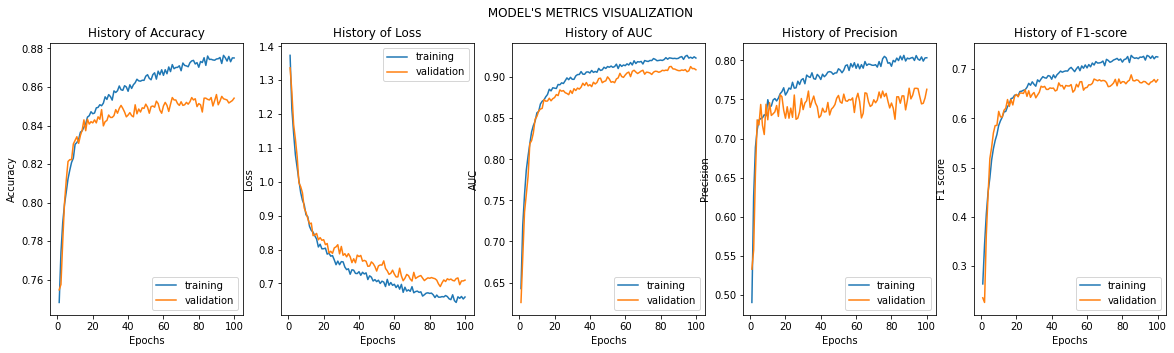

In [35]:
def Train_Val_Plot(acc,val_acc,loss,val_loss,auc,val_auc,precision,val_precision,f1,val_f1):
    
    fig, (ax1, ax2,ax3,ax4,ax5) = plt.subplots(1,5, figsize= (20,5))
    fig.suptitle(" MODEL'S METRICS VISUALIZATION ")

    ax1.plot(range(1, len(acc) + 1), acc)
    ax1.plot(range(1, len(val_acc) + 1), val_acc)
    ax1.set_title('History of Accuracy')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Accuracy')
    ax1.legend(['training', 'validation'])


    ax2.plot(range(1, len(loss) + 1), loss)
    ax2.plot(range(1, len(val_loss) + 1), val_loss)
    ax2.set_title('History of Loss')
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel('Loss')
    ax2.legend(['training', 'validation'])
    
    ax3.plot(range(1, len(auc) + 1), auc)
    ax3.plot(range(1, len(val_auc) + 1), val_auc)
    ax3.set_title('History of AUC')
    ax3.set_xlabel('Epochs')
    ax3.set_ylabel('AUC')
    ax3.legend(['training', 'validation'])
    
    ax4.plot(range(1, len(precision) + 1), precision)
    ax4.plot(range(1, len(val_precision) + 1), val_precision)
    ax4.set_title('History of Precision')
    ax4.set_xlabel('Epochs')
    ax4.set_ylabel('Precision')
    ax4.legend(['training', 'validation'])
    
    ax5.plot(range(1, len(f1) + 1), f1)
    ax5.plot(range(1, len(val_f1) + 1), val_f1)
    ax5.set_title('History of F1-score')
    ax5.set_xlabel('Epochs')
    ax5.set_ylabel('F1 score')
    ax5.legend(['training', 'validation'])


    plt.show()
    

Train_Val_Plot(history.history['accuracy'],history.history['val_accuracy'],
               history.history['loss'],history.history['val_loss'],
               history.history['auc'],history.history['val_auc'],
               history.history['precision'],history.history['val_precision'],
               history.history['f1_score'],history.history['val_f1_score']
              )

1/1 [==============================] - 6s 6s/step
46.78 % chances are there that the image is MildDemented


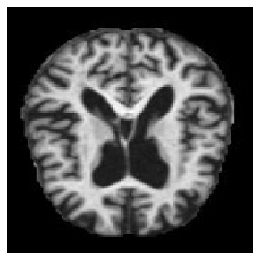

In [46]:
# Test Case 1: Non-Dementia

dic = test_dataset.class_indices
idc = {k:v for v, k in dic.items()}

img = tf.keras.utils.load_img('/content/dataset/Test/NonDemented/00bf1de7-3fa1-4027-8d9c-b44224391c7d.jpg', target_size = (331,331,3))
img =  tf.keras.utils.img_to_array(img)
img = img/255
imshow(img)
plt.axis('off')
img = np.expand_dims(img,axis=0)
#answer = model.predict_classes(img)
answer = np.argmax(model.predict(img), axis=1)
#probability = round(np.max(model.predict_proba(img)*100),2)
probability=round(np.max(model.predict_on_batch(img)*100),2)
print(probability, '% chances are there that the image is',idc[answer[0]])

1/1 [==============================] - 0s 66ms/step
66.72 % chances are there that the image is MildDemented


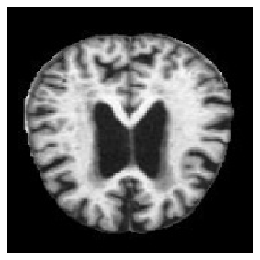

In [47]:
# Test Case 1: MildDemented

dic = test_dataset.class_indices
idc = {k:v for v, k in dic.items()}

img = tf.keras.utils.load_img('/content/dataset/Test/MildDemented/001f89e3-8207-4ee4-80d7-711c2acd191a.jpg', target_size = (331,331,3))
img =  tf.keras.utils.img_to_array(img)
img = img/255
imshow(img)
plt.axis('off')
img = np.expand_dims(img,axis=0)
#answer = model.predict_classes(img)
answer = np.argmax(model.predict(img), axis=1)
#probability = round(np.max(model.predict_proba(img)*100),2)
probability=round(np.max(model.predict_on_batch(img)*100),2)
print(probability, '% chances are there that the image is',idc[answer[0]])

1/1 [==============================] - 0s 66ms/step
97.95 % chances are there that the image is ModerateDemented


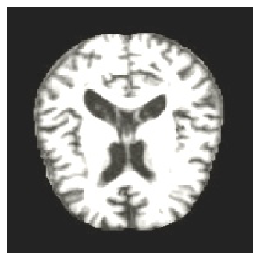

In [48]:
# Test Case 1: ModarateDemented

dic = test_dataset.class_indices
idc = {k:v for v, k in dic.items()}

img = tf.keras.utils.load_img('/content/dataset/Test/ModerateDemented/00a4080b-0cea-436f-9c97-031ee6d3b5f5.jpg', target_size = (331,331,3))
img =  tf.keras.utils.img_to_array(img)
img = img/255
imshow(img)
plt.axis('off')
img = np.expand_dims(img,axis=0)
#answer = model.predict_classes(img)
answer = np.argmax(model.predict(img), axis=1)
#probability = round(np.max(model.predict_proba(img)*100),2)
probability=round(np.max(model.predict_on_batch(img)*100),2)
print(probability, '% chances are there that the image is',idc[answer[0]])

1/1 [==============================] - 0s 65ms/step
60.84 % chances are there that the image is MildDemented


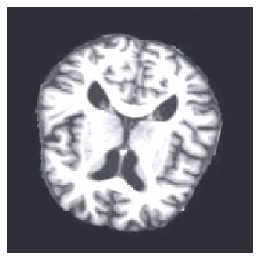

In [49]:
# Test Case 1: VeryMildDemented

dic = test_dataset.class_indices
idc = {k:v for v, k in dic.items()}

img = tf.keras.utils.load_img('/content/dataset/Test/VeryMildDemented/00a9e033-25a4-4382-b499-55d61241e077.jpg', target_size = (331,331,3))
img =  tf.keras.utils.img_to_array(img)
img = img/255
imshow(img)
plt.axis('off')
img = np.expand_dims(img,axis=0)
#answer = model.predict_classes(img)
answer = np.argmax(model.predict(img), axis=1)
#probability = round(np.max(model.predict_proba(img)*100),2)
probability=round(np.max(model.predict_on_batch(img)*100),2)
print(probability, '% chances are there that the image is',idc[answer[0]])

In [52]:
#Mild
dic = test_dataset.class_indices
idc = {k:v for v, k in dic.items()}

img_num = 0
correct_num = 0

for img_x in glob.glob("/content/dataset/Test/MildDemented/*.jpg"):
  img_num += 1
  img = tf.keras.utils.load_img(img_x, target_size = (331,331,3))
  img = tf.keras.utils.img_to_array(img)
  img = img/255
  img = np.expand_dims(img,axis=0)
  answer = np.argmax(model.predict(img), axis=1)
  probability=round(np.max(model.predict_on_batch(img)*100),2)
  if(idc[answer[0]] == "MildDemented"):
    correct_num +=1
print("correct: "+str(correct_num))
print("images: "+str(img_num))
print("percentage: "+str(correct_num/img_num))

1/1 [==============================] - 0s 49ms/step
correct: 457
images: 500
percentage: 0.914


In [57]:
#Modarate
dic = test_dataset.class_indices
idc = {k:v for v, k in dic.items()}

img_num = 0
correct_num = 0

for img_x in glob.glob("/content/dataset/Test/ModerateDemented/*.jpg"):
  img_num += 1
  img = tf.keras.utils.load_img(img_x, target_size = (331,331,3))
  img = tf.keras.utils.img_to_array(img)
  img = img/255
  img = np.expand_dims(img,axis=0)
  answer = np.argmax(model.predict(img), axis=1)
  probability=round(np.max(model.predict_on_batch(img)*100),2)
  if(idc[answer[0]] == "ModerateDemented"):
    correct_num +=1
print("correct: "+str(correct_num))
print("images: "+str(img_num))
print("percentage: "+str(correct_num/img_num))

1/1 [==============================] - 0s 49ms/step
correct: 493
images: 500
percentage: 0.986


In [54]:
#Non
dic = test_dataset.class_indices
idc = {k:v for v, k in dic.items()}

img_num = 0
correct_num = 0

for img_x in glob.glob("/content/dataset/Test/NonDemented/*.jpg"):
  img_num += 1
  img = tf.keras.utils.load_img(img_x, target_size = (331,331,3))
  img = tf.keras.utils.img_to_array(img)
  img = img/255
  img = np.expand_dims(img,axis=0)
  answer = np.argmax(model.predict(img), axis=1)
  probability=round(np.max(model.predict_on_batch(img)*100),2)
  if(idc[answer[0]] == "NonDemented"):
    correct_num +=1
print("correct: "+str(correct_num))
print("images: "+str(img_num))
print("percentage: "+str(correct_num/img_num))

1/1 [==============================] - 0s 51ms/step
correct: 404
images: 500
percentage: 0.808


In [58]:
#VeryMild
dic = test_dataset.class_indices
idc = {k:v for v, k in dic.items()}

img_num = 0
correct_num = 0

for img_x in glob.glob("/content/dataset/Test/VeryMildDemented/*.jpg"):
  img_num += 1
  img = tf.keras.utils.load_img(img_x, target_size = (331,331,3))
  img = tf.keras.utils.img_to_array(img)
  img = img/255
  img = np.expand_dims(img,axis=0)
  answer = np.argmax(model.predict(img), axis=1)
  probability=round(np.max(model.predict_on_batch(img)*100),2)
  if(idc[answer[0]] == "VeryMildDemented"):
    correct_num +=1
print("correct: "+str(correct_num))
print("images: "+str(img_num))
print("percentage: "+str(correct_num/img_num))

1/1 [==============================] - 0s 51ms/step
correct: 0
images: 500
percentage: 0.0


# Yeni Bölüm